In [1]:
import numpy as np
import os
import json
import pandas as pd
from utils.evaluation import *

data_path="/home/emartini/nas/MAEVE/dataset/panoptic-toolbox/trtpose3D/"

CONTINUOUS_STATE_PARTS = [
            "nose", "left_ear", "right_ear", "left_shoulder", "right_shoulder", 
            "left_elbow", "right_elbow", "left_wrist", "right_wrist", "left_hip", "right_hip", "left_knee", 
            "right_knee", "left_ankle", "right_ankle", "neck"]

# Load the json for comparison
mapping = [12, 7, 10, 4,  5, 9, 6, 8, 11, 3, 14, 13]
header = ["frame_id"]+[CONTINUOUS_STATE_PARTS[m] for m in mapping]

In [23]:
# Compared methods
from multiprocessing import Process, Manager
manager = Manager()

# cameras_list = [[6,7],[6,7,8],[6,7,8,9],[6,7,8,9,10]]
# cameras_list = [[6,7],[6,8],[6,9],[6,10],[7,8],[7,9],[7,10],[8,9],[8,10],[9,10]]

# All the combinantions
cameras_list = [[6], [7], [8], [9], [10]] +\
                generate_combinations([6,7,8,9,10],2)+\
                generate_combinations([6,7,8,9,10],3)+\
                generate_combinations([6,7,8,9,10],4)+\
                generate_combinations([6,7,8,9,10],5)

cameras_list = [[7]]

methods = ["befine","cometh"] # "befine","cometh"
sequences = ["170915_office1"] #"170915_office1","161029_tools1","161029_build1","161029_sports1"] # ,"160422_ultimatum1" too long ;;"170407_haggling_a1",
result = []

for sequence_name in sequences:
    print(sequence_name)
    for cameras in cameras_list:
        print("cams:",cameras)
        for method in methods:
            print(method)
            
            # Load ground truth
            GT = {}
            with open(os.path.join(data_path,sequence_name+".gt.json"), "r") as f:
                ground_truth = json.load(f)
            for frame in ground_truth:
                GT[frame["timestamp"]] = frame        

            # Load camera file
            DUT = {}
            with open(os.path.join(data_path,sequence_name+"."+ method+"." +".".join(map(str, cameras)) +".json" ), "r") as f:
                file = json.load(f)
            for frame in file:
                DUT[frame["timestamp"]] = frame    

            ## Build the triple nested list (shape: n_frames, n_people, n_joints, 3) and IDs (shape: n_frames, n_people)
            # union of both gt and camera            
            ids = list(GT.keys())
            for frame_dut in list(DUT.keys()):
                if frame_dut not in ids:
                    ids.append(frame_dut) 
                    
            predicted_keypoints = []
            predicted_ids = []
            ground_truth_keypoints = []
            ground_truth_ids = []
            for id in sorted(ids):
                predicted_keypoints_per_frame = []
                predicted_ids_per_frame = []
                ground_truth_keypoints_per_frame = []
                ground_truth_ids_per_frame = []
                if id in GT.keys():
                    for pp in GT[id]['continuousState']:
                        s = np.array([ [np.nan,np.nan,np.nan] if not f else f for f in pp])
                        s = s[mapping,:]
                        ground_truth_keypoints_per_frame.append(s)
                    for i in GT[id]['track_ids']:
                        ground_truth_ids_per_frame.append(i)
                if id in DUT.keys():
                    for i,pp in enumerate(DUT[id]['continuousState']):
                        s = np.array([ [np.nan,np.nan,np.nan] if not f else f for f in pp])
                        s = s[mapping,:]
                        if not np.isnan(s).all():
                            predicted_keypoints_per_frame.append(s)
                            # predicted_ids_per_frame.append(i)

                    # This doesn't work for cameras
                    for I in DUT[id]['track_ids']:
                        predicted_ids_per_frame.append(I)
                # print(id)
                # if id > 500:
                #     # print(GT[id]['continuousState'])
                #     # print(predicted_keypoints_per_frame)
                #     # print(predicted_ids_per_frame)
                #     # print(ground_truth_keypoints_per_frame)
                #     # print(ground_truth_ids_per_frame)
                #     break
                
                predicted_keypoints.append(predicted_keypoints_per_frame)
                predicted_ids.append(predicted_ids_per_frame)
                ground_truth_keypoints.append(ground_truth_keypoints_per_frame)
                ground_truth_ids.append(ground_truth_ids_per_frame)

            # print(predicted_keypoints)

            # Integral
            # res = [[]]*19
            res = manager.list()
            procs = []
            step = 0.05
            thread_id = 0
            while step < 1:
                # print(step)
                # loca, deta, detpr, detre, assa,asspr,assre, hot = hota(predicted_keypoints, predicted_ids, ground_truth_keypoints, ground_truth_ids,distance_threshold=step)
                # res.append([step, loca, deta, detpr, detre, assa,asspr,assre, hot])
                proc = Process(target=hota_par, args=(res,thread_id,predicted_keypoints, predicted_ids, ground_truth_keypoints, ground_truth_ids,step))
                
                procs.append(proc)
                proc.start()
                step += 0.05
                thread_id += 1

            for proc in procs:
                proc.join()
            res = list(res)
            
            # row = [sequence_name,len(cameras),method] + list(np.nanmean(np.array(res),0)[1:])
            row = [sequence_name,len(cameras),",".join(map(str, cameras)),method] + np.round(list(100*np.nanmean(np.array(res),0)),1).tolist()
            result.append(row)

header_stats = ["Sequence","#Cams","Cams", "Aggregator",  "LocA", "DetA", "DetPR", "DetRE", "AssA","AssPR","AssRE", "HOTA"]
df = pd.DataFrame(result,columns=header_stats)
df

170915_office1
cams: [7]
befine
cometh


,Sequence,#Cams,Cams,Aggregator,LocA,DetA,DetPR,DetRE,AssA,AssPR,AssRE,HOTA
0,170915_office1,1,7,befine,73.0,85.5,91.4,93.1,87.7,93.9,93.1,86.6
1,170915_office1,1,7,cometh,71.4,50.0,66.6,66.7,47.9,94.3,49.3,48.9


In [18]:
# df.to_csv(os.path.join(data_path,sequence_name+'.csv'), index=False)
print(df.to_string())
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
#     print(df.to_string())


         Sequence  #Cams        Cams Aggregator  LocA  DetA  DetPR  DetRE  AssA  AssPR  AssRE  HOTA
0   161029_build1      1           6     befine  73.8  63.0   81.6   73.4  16.1   19.8   46.1  31.8
1   161029_build1      1           6     cometh  72.5  55.7   77.4   66.6  24.4   84.3   25.5  36.9
2   161029_build1      1           7     befine  72.4  73.1   85.7   83.2  21.8   26.1   57.0  39.9
3   161029_build1      1           7     cometh  72.6  67.2   82.2   78.7  63.5   90.9   67.8  65.3
4   161029_build1      1           8     befine  73.7  72.5   84.5   83.6  21.0   25.5   54.4  39.0
5   161029_build1      1           8     cometh  72.1  52.4   71.3   66.4  23.0   74.9   24.9  34.7
6   161029_build1      1           9     befine  74.3  82.0   91.3   88.9  19.7   24.2   51.6  40.2
7   161029_build1      1           9     cometh  75.1  69.4   84.1   79.9  55.4   96.0   56.7  62.0
8   161029_build1      1          10     befine  74.5  74.1   87.0   83.2  27.8   31.1   72.0  45.4


In [19]:
DF = df
# DF = pd.read_csv(os.path.join(data_path,'results.csv'))
cam_grouped = DF.groupby(["#Cams","Aggregator"]).mean()
DF.groupby(["Aggregator","#Cams"]).mean()
DF.groupby(["#Cams","Aggregator"]).mean()

LocA   DetA  DetPR  DetRE   AssA  AssPR  AssRE   HOTA
#Cams Aggregator                                                        
1     befine      73.74  72.94  86.02  82.46  21.28  25.34  56.22  39.26
      cometh      73.50  62.14  79.38  73.78  44.48  86.14  47.48  51.96
2     befine      80.85  89.43  95.72  93.11  21.48  25.55  56.98  43.78
      cometh      79.11  85.67  92.15  92.18  75.49  96.03  77.62  80.25
3     befine      82.55  89.52  94.06  94.85  20.66  24.74  55.28  42.94
      cometh      83.11  92.11  95.05  96.61  91.25  98.40  92.53  91.64
4     befine      82.76  88.46  92.52  95.22  19.42  23.52  52.58  41.42
      cometh      85.00  94.28  96.06  97.98  95.16  98.14  96.74  94.72
5     befine      82.80  87.10  91.10  95.20  18.60  22.70  50.70  40.30
      cometh      86.30  96.10  97.00  99.10  98.40  99.40  99.00  97.30

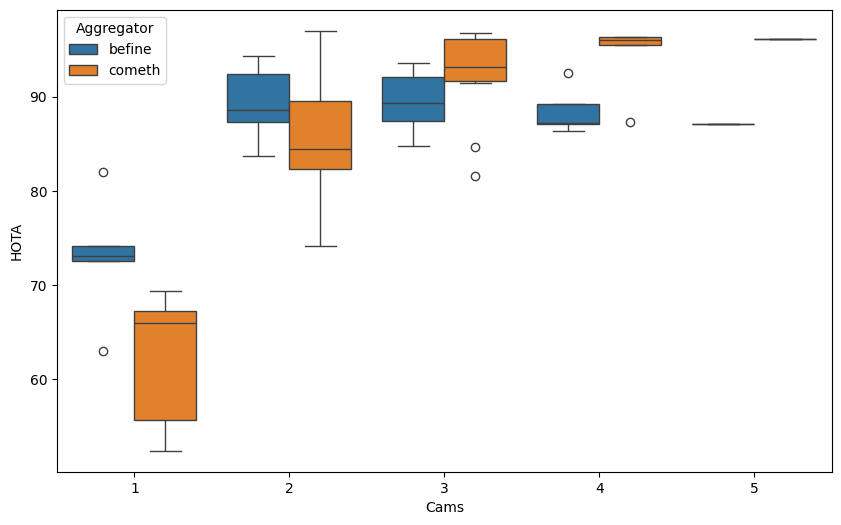

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
#.unstack().boxplot(column="HOTA",by="Aggregator",title="HOTA",ylim=(0,100))
# cam_grouped["HOTA"].unstack().plot(kind='bar',title="HOTA",ylim=(0,100))
# cam_grouped["DetA"].unstack().plot(kind='bar',title="DetA",ylim=(0,100))
# cam_grouped["AssA"].unstack().plot(kind='bar',title="AssA",ylim=(0,100))
# cam_grouped["LocA"].unstack().plot(kind='bar',title="LocA",ylim=(0,100))
# DF[["Aggregator","#Cams","HOTA"]].groupby(["Aggregator","#Cams"]).min()
plt.figure(figsize=(10, 6))
sns.boxplot(x='#Cams', y='DetA', hue='Aggregator',  data=DF)
# plt.title('Boxplot of HOTA by #Cams')
plt.xlabel('Cams')
plt.ylabel('HOTA')
plt.show()

In [ ]:
# Build qualitative json method vs ground truth (matching based on frame_id)
import collections
result = collections.Counter(list(DUT.keys())) & collections.Counter(list(GT.keys()))
intersected_list = list(result.elements())
# print(DUT.keys())
out = []
for i in intersected_list:
    f_gt = GT[i]
    f_dut = DUT[i]
    summed = f_gt.copy()
    summed["kp3d"] += f_dut["kp3d"]
    summed["kp2d"] += f_dut["kp2d"]
    summed["continuousState"] += f_dut["continuousState"]
    summed["track_ids"] += [id + 50 for id in f_dut["track_ids"]]
    # print(summed)
    # print(f_gt["timestamp"],f_dut["timestamp"])
    out.append(summed)
    # break

# dump json
filename = os.path.join(data_path,sequence_name+".gt_vs_"+method+"." +".".join(map(str, cameras))+".json")
print("Written",filename)

with open(filename, "w") as outfile:
    json.dump(out, outfile)

# Export in viewer format
os.system('python3 to_viewer.py ' + filename + ' --rotation 180 --output '+filename.replace('.json','.viewer.json')+' >> "tmp/"$1"_log_2.txt"')

In [ ]:
# Build qualitative json method vs ground truth (matching based on timestamps)
GT_t = {}
for frame in list(GT.keys()):
    GT_t[GT[frame]["timestamp"]] = GT[frame]

DUT_t = {}
for frame in list(DUT.keys()):
    DUT_t[DUT[frame]["timestamp"]] = DUT[frame]
          
import collections
result = collections.Counter(list(DUT_t.keys())) & collections.Counter(list(DUT_t.keys()))
intersected_list = list(result.elements())
# print(DUT.keys())
intersected_list.remove(0)
out = []
for i in intersected_list:
    print(i)
    summed = {}
    f_gt = GT_t[i]
    f_dut = DUT_t[i]
    # summed = f_gt.copy()
    summed["timestamp"] = f_gt["timestamp"]
    summed["frame_id"] = f_gt["frame_id"]
    summed["kp3d"] = f_gt["kp3d"]+f_dut["kp3d"]
    summed["kp2d"] = f_gt["kp2d"]+f_dut["kp2d"]
    summed["continuousState"] = f_gt["continuousState"]+f_dut["continuousState"]
    summed["track_ids"] = f_gt["track_ids"]+ [id + 50 for id in f_dut["track_ids"]]

    out.append(summed)

# dump json
filename = os.path.join(data_path,sequence_name+".gt_vs_"+method+"." +".".join(map(str, cameras))+".json")

with open(filename, "w") as outfile:
    json.dump(out, outfile)

# Export in viewer format
os.system('python3 to_viewer.py ' + filename + ' --rotation 180 --output '+filename.replace('.json','.viewer.json')+' >> "tmp/"$1"_log_2.txt"')